- Data selection and pre-processing, like removing NaN values and empty lines, transforming text columns to numerical values of one-hot-encoding.

- Train and test data separation

- Model training, including brief investigation of hyperparameters.

- Model result evaluation, the success rate of the prediction

- Confusion matrix

- SHAP analysis

In [1]:
import pandas as pd
path = "/content/fraud_challenge_150k.csv"
df_raw = pd.read_csv(path)

In [2]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

 =============keep it as it is===============     
 0   account_age_days       149892 non-null  float64    
 1   transaction_amt        149870 non-null  float64     
 2   transaction_adj_amt    149886 non-null  float64    
 3   historic_velocity      149885 non-null  float64  
 23  days_since_last_logon  149864 non-null  float64       
 24  inital_amount          149872 non-null  float64   
 ==========  keep but modify=================     
 6   email_domain           149910 non-null  object     
 8   billing_city           149884 non-null  object  
 10  billing_state          149887 non-null  object  
 12  currency               149892 non-null  object    
 13  cvv                    149877 non-null  object    
 14  signature_image        149895 non-null  object   
 15  transaction_type       149884 non-null  object   
 16  transaction_env        149877 non-null  object     
 22  tranaction_initiate    149874 non-null  object     
 =============Exclude========================     
 4   ip_address             149873 non-null  object             
 5   user_agent             149887 non-null  object    
 7   phone_number           149873 non-null  object     
 9   billing_postal         149876 non-null  float64    
 11  card_bin               149872 non-null  float64    
 17  EVENT_TIMESTAMP        149888 non-null  object     
 18  applicant_name         149857 non-null  object     
 19  billing_address        149866 non-null  object     
 20  merchant_id            149893 non-null  object     
 21  locale                 149866 non-null  object            

In [4]:
df = df_raw.drop(columns=['ip_address','user_agent','phone_number','billing_postal','card_bin','EVENT_TIMESTAMP','applicant_name','billing_address','merchant_id','locale'])
df.head()


,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,email_domain,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,perez-garza.com,Woodsburgh,California,cad,D,F,U,X,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,mcneil-ortega.com,West Kevin,Florida,cad,X,X,H,W,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,davis-calderon.com,Lorichester,Utah,cad,X,Q,X,X,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,rose-lee.org,Stephenmouth,Virginia,usd,G,G,C,N,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,nash.net,New Brianmouth,South Carolina,cad,X,F,F,G,K,21.0,1905.0,legit


removing non values and empty lines

In [ ]:
# one-hot encoding
# hotlist = ['email_domain','billing_city','billing_state','currency','cvv','signature_image','transaction_type','transaction_env','tranaction_initiate']
# for i in range(len(hotlist)):
#   one_hot_encoded_X = pd.get_dummies(df[hotlist[i]], prefix=hotlist[i]).astype(int)
#   df = pd.concat([df, one_hot_encoded_X], axis=1)
#   df = df.drop(columns = [hotlist[i]])

In [5]:
# columns where parameters values are alphabetic letters
df = df.replace({'transaction_env':{chr(i+64): i for i in range(1,27)}})
df = df.replace({'cvv':{chr(i+64): i for i in range(1,27)}})
df = df.replace({'signature_image':{chr(i+64): i for i in range(1,27)}})
df = df.replace({'transaction_type':{chr(i+64): i for i in range(1,27)}})
df = df.replace({'tranaction_initiate':{chr(i+64): i for i in range(1,27)}})

#Tokenization
df['email_domain'] = df.groupby('email_domain')['email_domain'].transform('count')
df['billing_city'] = df.groupby('billing_city')['billing_city'].transform('count')
df['billing_state'] = df.groupby('billing_state')['billing_state'].transform('count')
df['currency'] = df.groupby('currency')['currency'].transform('count')

In [6]:
# Fix labels
df.loc[df['EVENT_LABEL'].str.contains('legit', na=False), 'EVENT_LABEL'] = 1
df.loc[df['EVENT_LABEL'].str.contains('fraud', na=False), 'EVENT_LABEL'] = 0
df['EVENT_LABEL'] = df['EVENT_LABEL'].astype(int)
df.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,email_domain,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,46.0,43.0,7813.0,113751.0,4.0,6.0,21.0,24.0,15.0,59.0,13646.0,1
1,2714.0,2045.0,48.0,4517.0,38.0,38.0,5115.0,113751.0,24.0,24.0,8.0,23.0,10.0,0.0,11930.0,1
2,6987.0,2892.0,61.0,5007.0,23.0,30.0,6591.0,113751.0,24.0,17.0,24.0,24.0,20.0,83.0,7412.0,1
3,2712.0,3040.0,28.0,6022.0,22.0,27.0,6756.0,31768.0,7.0,7.0,3.0,14.0,13.0,24.0,4623.0,1
4,3598.0,2976.0,66.0,2600.0,45.0,32.0,2826.0,113751.0,24.0,6.0,6.0,7.0,11.0,21.0,1905.0,1


In [ ]:
df.dropna(inplace=True)
df

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,email_domain,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,perez-garza.com,Woodsburgh,California,cad,D,F,U,X,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,mcneil-ortega.com,West Kevin,Florida,cad,X,X,H,W,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,davis-calderon.com,Lorichester,Utah,cad,X,Q,X,X,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,rose-lee.org,Stephenmouth,Virginia,usd,G,G,C,N,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,nash.net,New Brianmouth,South Carolina,cad,X,F,F,G,K,21.0,1905.0,legit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,3986.0,2890.0,57.0,4544.0,garza-harper.org,West Tara,Washington,cad,W,D,S,W,M,99.0,6681.0,legit
149996,5834.0,1875.0,61.0,4369.0,henderson-rivas.com,New Sarafurt,Indiana,cad,I,X,W,Z,I,85.0,2402.0,legit
149997,4781.0,3371.0,48.0,5135.0,larsen-wright.com,Priceburgh,Illinois,cad,D,H,I,D,G,22.0,4113.0,legit
149998,6085.0,2306.0,59.0,4846.0,hughes-chen.com,Rogersbury,Oklahoma,cad,X,U,Z,X,W,70.0,4531.0,legit


In [7]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.7 MB/s eta 0:00:00


In [8]:
!pip install graphviz

In [9]:
# Import ML library
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import shap
import xgboost
import os


In [10]:
Y = df['EVENT_LABEL'] #target
dfx = df.drop(columns = ['EVENT_LABEL'], axis = 1)
df_columns = dfx.columns
#Transform text data to numerical format:
X = dfx.apply(pd.to_numeric)


[X_train, X_test, y_train, y_test] = train_test_split(X, Y, train_size=0.7)

X_train = pd.DataFrame(data = X_train, columns = df_columns)
X_test = pd.DataFrame(data = X_test, columns = df_columns)
X_train.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,email_domain,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,tranaction_initiate,days_since_last_logon,inital_amount
135502,4355.0,2926.0,37.0,3912.0,38.0,12.0,5897.0,113751.0,19.0,3.0,7.0,8.0,4.0,22.0,6136.0
115124,4474.0,2638.0,53.0,5567.0,36.0,27.0,4918.0,31768.0,23.0,21.0,4.0,23.0,3.0,86.0,1914.0
122153,4719.0,2637.0,44.0,3565.0,8.0,24.0,8628.0,31768.0,7.0,19.0,23.0,24.0,8.0,31.0,11758.0
131980,5734.0,3025.0,66.0,5915.0,56.0,27.0,4918.0,113751.0,9.0,19.0,7.0,4.0,10.0,100.0,14225.0
104380,4039.0,1705.0,72.0,2444.0,19.0,25.0,8555.0,113751.0,3.0,24.0,24.0,6.0,20.0,17.0,14771.0


In [11]:
# Modeling
model = xgboost.XGBClassifier(n_estimators=5, tree_method='hist', subsample=0.7, n_jobs = 6, random_state= 0)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=6,
              num_parallel_tree=None, random_state=0, ...)

In [12]:
print("The model accuracy on training dataset is :", np.round(model.score(X_train, y_train)))
print("The model accuracy on testing dataset is :", np.round(model.score(X_test, y_test)))

y_pred = model.predict(X_test)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

print("The model precision on testing dataset is :", np.round(precision, 3))
print("The model recall on testing dataset is :", np.round(recall, 3))
print("The model f1_score on testing dataset is :", np.round(f1_score, 3))

The model accuracy on training dataset is : 1.0
The model accuracy on testing dataset is : 1.0
The model precision on testing dataset is : 0.971
The model recall on testing dataset is : 0.997
The model f1_score on testing dataset is : 0.984


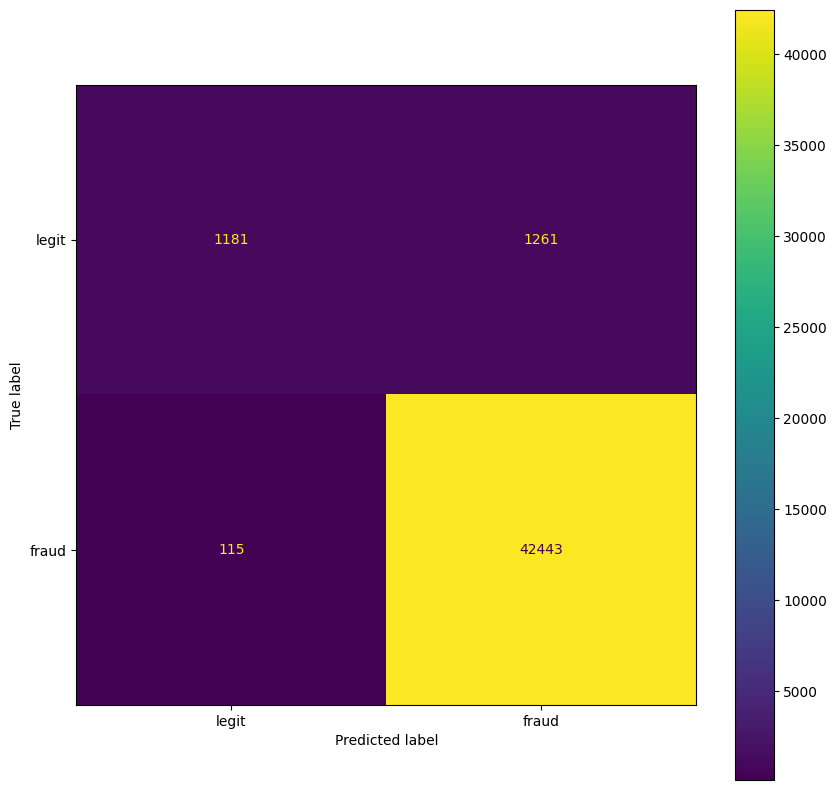

In [13]:
# confusion matrix
rcParams['figure.figsize'] = 10,10
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels = ['legit','fraud'])
cm.plot()
plt.show()

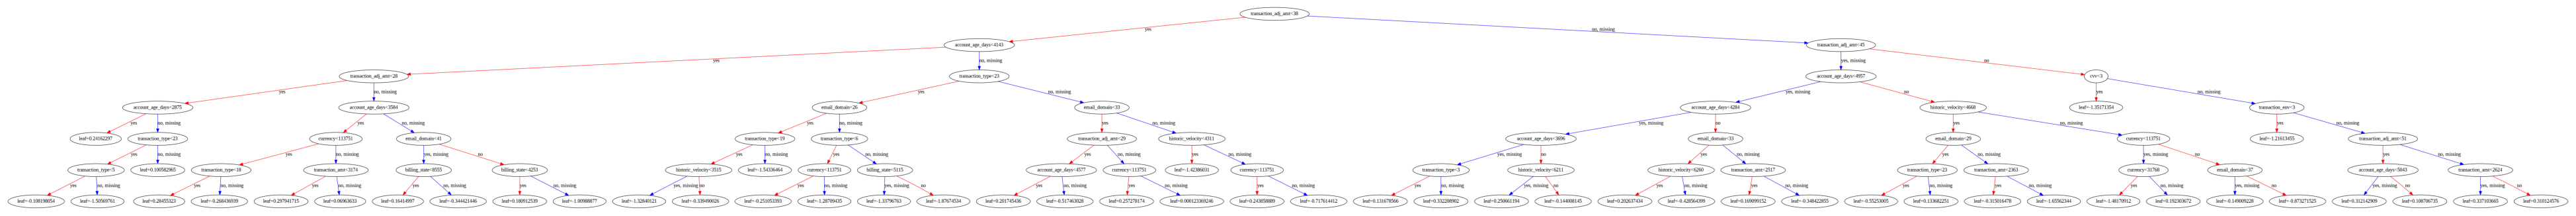

In [14]:
#show the decision tree
rcParams['figure.figsize'] = 50,20
xgboost.plot_tree(model, fontsize=20)
plt.show()

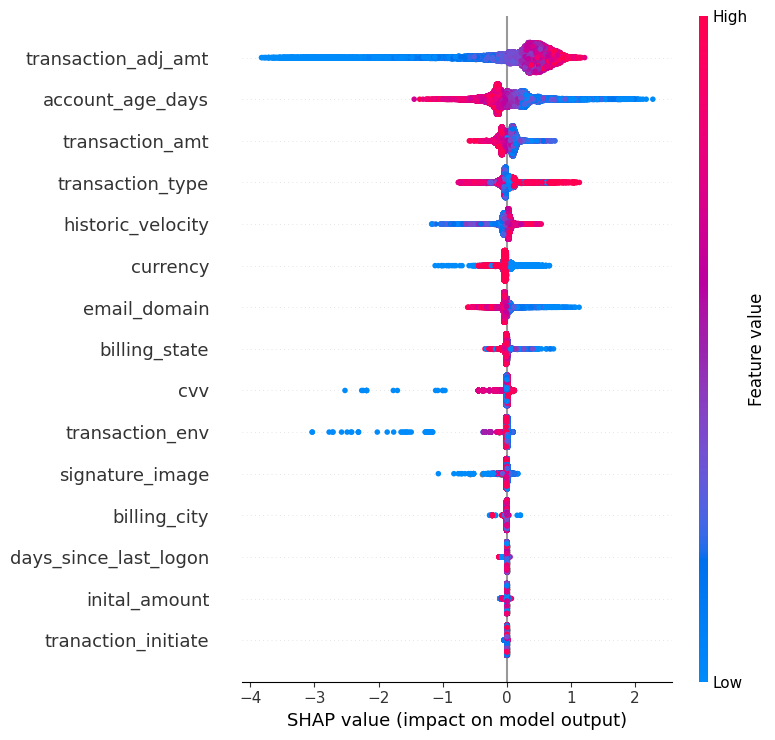

In [15]:
#SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

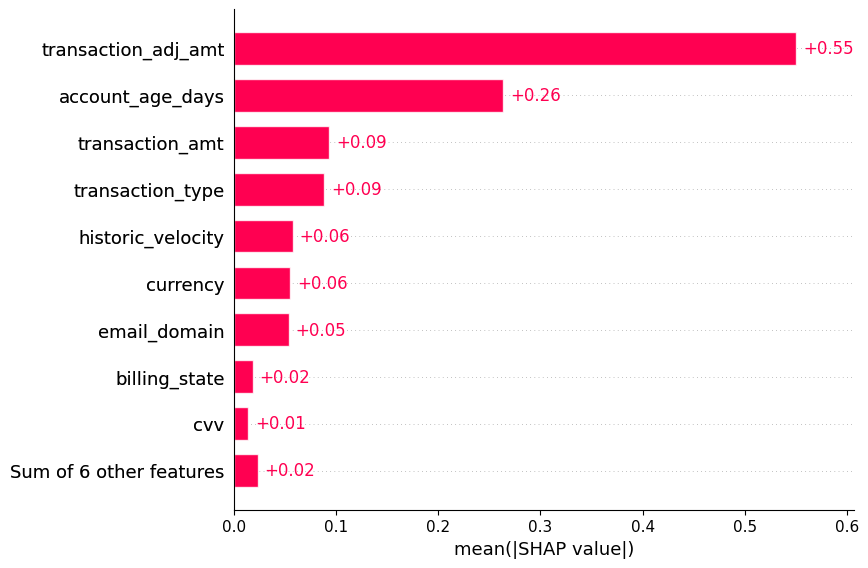

In [16]:
# show the importance of the parameters
values = explainer(X_test)
shap.plots.bar(values)


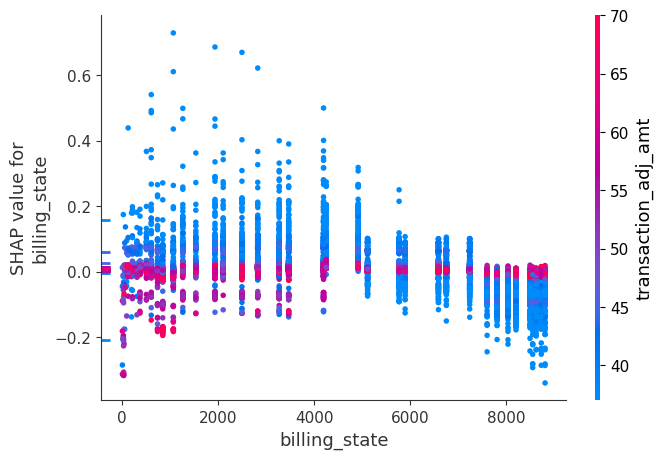

In [20]:
shap.dependence_plot("billing_state", shap_values, X_test,interaction_index="transaction_adj_amt")